<a href="https://colab.research.google.com/github/Abay32/Abay32/blob/main/housePrice_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import files
import io
upload = files.upload()


Saving test.csv to test.csv
Saving train.csv to train.csv


In [4]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


1460


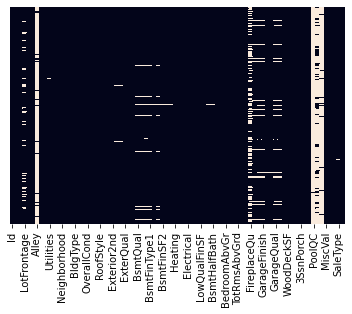

In [5]:
# plot the nan values per each column 
sns.heatmap(df.isnull(), yticklabels= False, cbar = False)
sns.heatmap(df_test.isnull(), yticklabels=False, cbar=False)
print(df.shape[0])

In [6]:
def handle_missing_values(data):
    test1 = data.loc[:, data.isnull().any()]
    col = test1.select_dtypes(include=['object']).columns.tolist()#Categorical columns 
    #print(sorted(col))
    col_num = test1._get_numeric_data().columns.tolist()
    
    # Handling categorical mising values 
    for i in col:
        if data[i].isnull().sum() < data.shape[0]/2:
            data[i] = data[i].fillna(data[i].mode()[0])
        else:
            data.drop(i, axis=1, inplace=True)
            
    # Handling numerical values 
    for item in col_num:
        if data[item].isnull().sum() < data.shape[0]/2:
            data[item] = data[item].fillna(data[item].mode()[0])
        else:
            data.drop(item, axis=1, inplace=True)
    return data 

# Handle missing values 


In [7]:
df_train = handle_missing_values(df)
df_train.drop('Id', axis = 1, inplace=True)# Drop the index

df_test = handle_missing_values(df_test)
df_test.drop('Id', axis = 1, inplace=True)
set(df_train.columns)-set(df_test.columns)

{'FireplaceQu', 'SalePrice'}

In [8]:
df_train.drop('FireplaceQu', axis=1, inplace=True)

# Concatinate the test-train data 

In [9]:
final_df = pd.concat([df_train, df_test], axis=0)
#df_train.shape#isnull().sum()
df.shape

(1460, 75)

## We need to handle categorical features 


In [10]:
col = df.select_dtypes(include=['object']).columns.tolist()
def category_onehot_coding(col):
    df_final, i = final_df, 0
    for fields in col:
        #print(fields)
        df1 = pd.get_dummies(final_df[fields], drop_first=True)        
        final_df.drop([fields], axis=1, inplace=True)
        if i==0:
            df_final = df1.copy()
        else:
            df_final = pd.concat([df_final, df1], axis=1)
        i += 1
    df_final = pd.concat([final_df, df_final], axis = 1)    
    return df_final
#from sklearn.preprocessing import OneHotEncoder
#def category_encoder(column, data):
#    encoder = OneHotEncoder()
#    for col in column:
#        reshaped = np.array(data[col]).reshape(-1, 1)
#        new_ddf = encoder.fit_transform(reshaped)
        

final_df = category_onehot_coding(col)
final_df.shape

(2919, 233)

In [11]:
final_df =final_df.loc[:,~final_df.columns.duplicated()]
df_chck = final_df.loc[:, final_df.isnull().any()]
df_chck

,SalePrice
0,208500.0
1,181500.0
2,223500.0
3,140000.0
4,250000.0
...,...
1454,NaN
1455,NaN
1456,NaN
1457,NaN


# The next step is train model

In [12]:
df_train = final_df.iloc[0:1460,:]
df_test = final_df.iloc[1460:, :]
df_test.drop('SalePrice', axis=1)
df_test.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,FV,RH,RL,...,No,BLQ,GLQ,LwQ,Rec,Unf,GasA,GasW,Grav,OthW,Wall,Y,FuseF,FuseP,Mix,SBrkr,Maj2,Min1,Min2,Typ,Attchd,Basment,BuiltIn,CarPort,Detchd,RFn,P,CWD,Con,ConLD,ConLI,ConLw,New,Oth,WD,AdjLand,Alloca,Family,Normal,Partial
0,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1961.0,1.0,730.0,140,0,0,0,120,0,0,6,2010,NaN,0,1,0,...,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1958.0,1.0,312.0,393,36,0,0,0,0,12500,6,2010,NaN,0,0,1,...,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,1997.0,2.0,482.0,212,34,0,0,0,0,0,3,2010,NaN,0,0,1,...,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,60,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,324.0,926.0,926,678,0,1604,0.0,0.0,2,1,3,1,7,1,1998.0,2.0,470.0,360,36,0,0,0,0,0,6,2010,NaN,0,0,1,...,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,120,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,1017.0,1280.0,1280,0,0,1280,0.0,0.0,2,0,2,1,5,0,1992.0,2.0,506.0,0,82,0,0,144,0,0,1,2010,NaN,0,0,1,...,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [13]:
y_train = df_train['SalePrice']
x_train = df_train.drop(['SalePrice'], axis=1)

# Prediction and Selecting the Algorithm


In [14]:
import sklearn

In [15]:
import xgboost
from sklearn.model_selection import RandomizedSearchCV
def xgb_regressor():
    regressor = xgboost.XGBRegressor()

    booster = ['gbtree', 'gblinear']
    base_score = [0.25 ,0.5, 0.75, 1]
    n_estimators = [100, 500, 900, 1100, 1500]
    max_depth = [2,3,5,10,15]
    learning_rate = [0.05, 0.1, 0.15, 0.2]
    min_child_weight = [1,2,3,4]
    
    # Define the grid of hyperparameters to search
    hyper_para_grid = {
        'n_estimators':n_estimators,
        'max_depth': max_depth,
        'learning_rate': min_child_weight,
        'booster':booster,
        'base_score':base_score
    }
    #set up the random search with 4-fold cross validation 
    rand_cv = RandomizedSearchCV(estimator = regressor,
                                 param_distributions = hyper_para_grid,
                                 cv=5, n_iter=50,
                                 scoring = 'neg_mean_absolute_error',
                                 
                                 n_jobs = 4,
                                 verbose= 5,
                                 return_train_score = True,
                                 random_state = 42
                                )
    return rand_cv
rand_cv = xgb_regressor()


In [16]:
rand_cv.fit(x_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan             nan             nan -9.53910732e+04
             nan -2.78128751e+04 -8.76358908e+04             nan
             nan             nan -1.09653930e+35             nan
 -1.00478452e+05             nan -1.00529971e+05             nan
 -1.40858285e+05             nan -2.57946830e+04 -8.76359121e+04
             nan -9.57212218e+04 -2.78128751e+04 -2.17538000e+04
             nan -9.03213553e+04 -1.29342717e+35 -9.37969140e+04
 -8.76357363e+04             nan -2.61842848e+04             nan
             nan             nan -9.43153234e+04 -2.78119257e+04
             nan             nan             nan -8.76357363e+04
 -9.57211805e+04 -1.75188366e+35             nan -2.16789982e+04
             nan -9.12359761e+04 -2.78154357e+04             nan
 -2.17583640e+04 -9.57212218e+04]
  category=UserWarning,
/usr/local/lib/python3.

[11:51:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5, estimator=XGBRegressor(), n_iter=50, n_jobs=4,
                   param_distributions={'base_score': [0.25, 0.5, 0.75, 1],
                                        'booster': ['gbtree', 'gblinear'],
                                        'learning_rate': [1, 2, 3, 4],
                                        'max_depth': [2, 3, 5, 10, 15],
                                        'n_estimators': [100, 500, 900, 1100,
                                                         1500]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=5)

In [17]:
rand_cv.best_estimator_

XGBRegressor(booster='gblinear', learning_rate=1, max_depth=15,
             n_estimators=1100)

In [18]:
regressor = xgboost.XGBRegressor(booster='gblinear',
                                 learning_rate = 1, 
                                 max_depth = 15, 
                                 n_estimators=1100
                                 )

In [19]:
regressor.fit(x_train, y_train)

[11:53:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(booster='gblinear', learning_rate=1, max_depth=15,
             n_estimators=1100)

In [20]:
ypredict = regressor.predict(df_test.drop('SalePrice', axis = 1))
df_test.shape
x_train.shape

(1460, 176)

In [21]:
ypredict

array([143285.16, 171642.02, 184669.2 , ..., 179899.7 ,  94986.89,
       236248.47], dtype=float32)

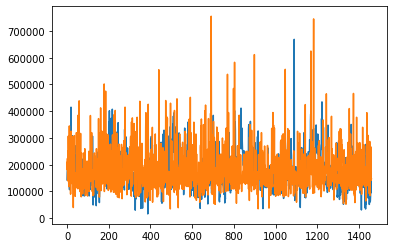

In [23]:
plt.plot(ypredict)
plt.plot(y_train)

Artificia Neura Network

In [24]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU,PReLU,ELU
from keras.layers import Dropout

from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 50, activation='relu', input_dim = 176))

# Adding the second hidden layer
classifier.add(Dense(units=25,activation='relu'))

# Adding the third hidden layer
classifier.add(Dense(units=50, activation='relu'))
# Adding the output layer
classifier.add(Dense(units = 1))

# Compiling the ANN
classifier.compile(loss = root_mean_squared_error, optimizer='Adamax')

# Fitting the ANN to the Training set
model_history=classifier.fit(x_train, y_train,validation_split=0.20, batch_size = 10, epochs=1000)


Epoch 1/1000
117/117 [==============================] - 2s 11ms/step - loss: 183659.8750 - val_loss: 165781.4219
Epoch 2/1000
117/117 [==============================] - 0s 2ms/step - loss: 104795.2578 - val_loss: 66643.3047
Epoch 3/1000
117/117 [==============================] - 1s 6ms/step - loss: 65595.9219 - val_loss: 64266.4453
Epoch 4/1000
117/117 [==============================] - 1s 5ms/step - loss: 65158.0430 - val_loss: 62852.6836
Epoch 5/1000
117/117 [==============================] - 0s 2ms/step - loss: 62823.9180 - val_loss: 61554.8164
Epoch 6/1000
117/117 [==============================] - 1s 8ms/step - loss: 61111.2891 - val_loss: 60357.9180
Epoch 7/1000
117/117 [==============================] - 0s 3ms/step - loss: 58849.9727 - val_loss: 59242.0547
Epoch 8/1000
117/117 [==============================] - 0s 2ms/step - loss: 56943.3945 - val_loss: 58136.8008
Epoch 9/1000
117/117 [==============================] - 0s 2ms/step - loss: 56121.1523 - val_loss: 56962.5117
Epoch 

In [26]:
ann_pred=classifier.predict(df_test.drop(['SalePrice'],axis=1).values)

In [27]:
ann_pred

array([[120386.695],
       [124782.93 ],
       [191187.6  ],
       ...,
       [201527.1  ],
       [116062.47 ],
       [207711.53 ]], dtype=float32)

In [29]:
ann = classifier.predict(x_train)


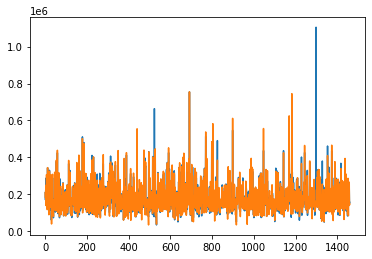

In [30]:
plt.plot(ann)
plt.plot(y_train)